In [1]:
from models import *
from utils import set_seed
from data.loaders import *
from utils import *

In [2]:
user = 'ajimenez'
path_to_model = f"/home/{user}/CoSE-pytorch/wandb/run-20210212_021205-1515u115/files/weights_trained/epoch_150"

In [3]:
set_seed(0)
device = torch.device('cuda:0')
cose = CoSEModel('config.json', False)

In [4]:
#optimizer_ae, optimizer_pos_pred, optimizer_emb_pred 
optimizers = cose.init_optimizers()


train_loader = get_batch_iterator(cose.config.train_dataset_path)

log_dir = f'/home/ajimenez/pruebas'

In [5]:
mean_channel, std_channel = get_stats(cose.config.stats_path)

In [6]:
for batch_input, batch_target in iter(train_loader):
    break

In [7]:
encoder_inputs = batch_input['encoder_inputs'].squeeze(dim = 0)
num_strokes = batch_input['num_strokes'].squeeze(dim = 0)
strok_len_inputs = batch_input['seq_len'].squeeze(dim = 0)
start_coord = batch_input['start_coord'].squeeze(dim = 0).squeeze()
end_coord = batch_input['end_coord'].squeeze(dim = 0).squeeze()

enc_inputs = encoder_inputs.reshape(-1, num_strokes.max(), encoder_inputs.size(1), encoder_inputs.size(2))
seq_len = strok_len_inputs.reshape(-1, num_strokes.max())
st_coord = start_coord.reshape(-1,num_strokes.max(), start_coord.size(1))

target_ink = batch_target['t_target_ink'].squeeze(dim = 0).to(device)
target_strok_len = batch_target["seq_len"].squeeze(dim = 0)
target_pos = batch_target["start_coord"].squeeze(dim =  0)
target_strokes = batch_target["stroke"].squeeze(dim = 0)
target_num_strokes = batch_target["num_strokes"].squeeze(dim = 0)

i_diagram = 0

npfig, fig, _, _ = transform_strokes_to_image(enc_inputs[i_diagram], seq_len[i_diagram], st_coord[i_diagram], mean_channel,
                               std_channel, num_strokes=num_strokes[i_diagram], stroke_pred=None, start_coord_pred=None, output_path = log_dir, output_file = 'noutput_pruebas',  save  = True, square_figure=True, alpha=0.5, highlight_start=True)

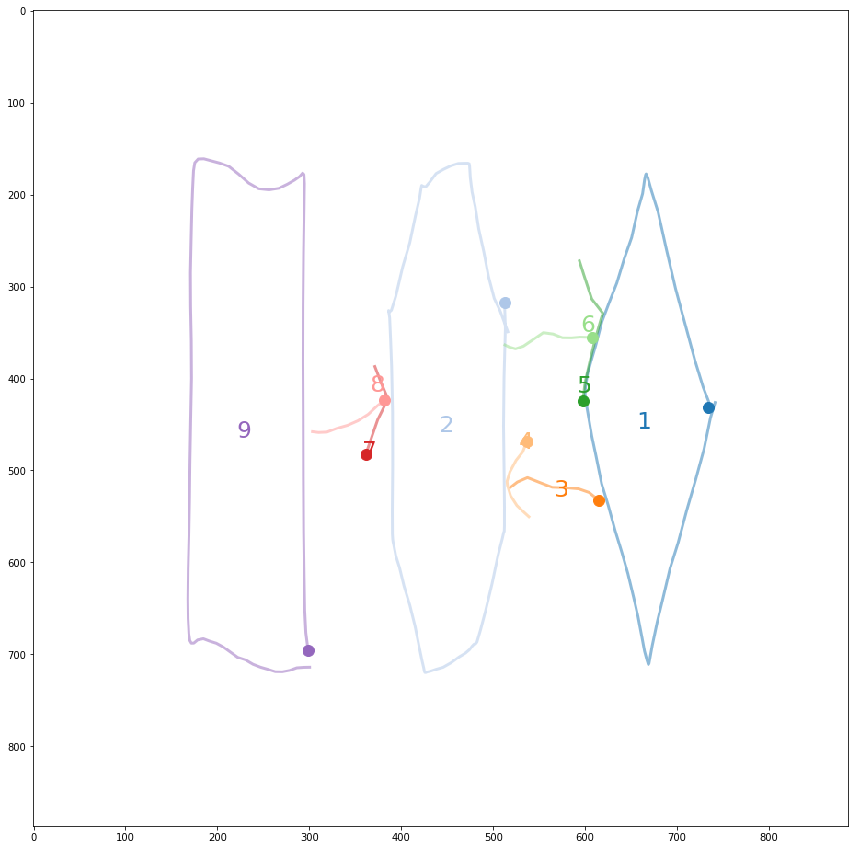

In [8]:
plt.figure(figsize = (15,15))
plt.imshow(npfig)

In [9]:
def get_arbitrary_ordered_batch(num_strokes_x_diagram_tensor, padded_max_num_strokes, num_diagrams, min_n_stroke, device, n_inputs = 2, start_index =  0):
    start_index = 0
    target_indexes = torch.tensor([start_index+n_inputs]).repeat(num_diagrams,1).to(device)
    input_range = torch.arange(start=0, end = padded_max_num_strokes).repeat(num_diagrams,1).to(device)
    mask = ((input_range)< target_indexes) & ((input_range)>= start_index)
    input_indexes = input_range.masked_select(mask).reshape(num_diagrams, n_inputs)
    return input_indexes, target_indexes, n_inputs

In [10]:
def train_ae(train_loader, optimizer_ae, optimizer_pos_pred, optimizer_emb_pred):
    i = 0
    for batch_input, batch_target in iter(train_loader):
        optimizer_ae.zero_grad()

        enc_inputs, t_inputs, stroke_len_inputs, inputs_start_coord, inputs_end_coord, num_strokes_x_diagram_tensor = parse_inputs(batch_input,cose.device)
        t_target_ink = parse_targets(batch_target,cose.device)
        # Creating sequence length mask
        comb_mask , look_ahead_mask, _ = generate_3d_mask(enc_inputs, stroke_len_inputs, cose.device, cose.config.enc_nhead)
        # Encoder forward
        #print("enc_inputs", enc_inputs.shape)
        x_ = enc_inputs[:,:,0]
        y_ = enc_inputs[:,:,1]
        enc_inputs[:,:,0] = (x_ - x_.min().item())/(x_.max().item() - x_.min().item())
        enc_inputs[:,:,1] = (y_ - y_.min().item())/(y_.max().item() - y_.min().item())
        encoder_out = cose.encoder(enc_inputs, stroke_len_inputs, comb_mask)
        # decoder forward
        encoder_out_reshaped = encoder_out.unsqueeze(dim=1).repeat(1,t_inputs.shape[1],1).reshape(-1, encoder_out.shape[-1])
        t_inputs_reshaped = t_inputs.reshape(-1,1)
        decoder_inp = torch.cat([encoder_out_reshaped, t_inputs_reshaped], dim = 1)
        strokes_out, ae_mu, ae_sigma, ae_pi= cose.decoder(decoder_inp)
        #
        loss_ae = -1*(logli_gmm_logsumexp(t_target_ink, ae_mu, ae_sigma, ae_pi)[t_target_ink.sum(dim=1) != 0].mean())
        loss_ae.backward()

        torch.nn.utils.clip_grad_norm_(cose.encoder.parameters(), .5)
        torch.nn.utils.clip_grad_norm_(cose.decoder.parameters(), .5)
        optimizer_pos_pred.step()
        optimizer_emb_pred.step()
        optimizer_ae.step()
    return (loss_ae, optimizer_ae, optimizer_pos_pred, optimizer_emb_pred)

# TRAINING AUTOENCODER ONLY

In [11]:
cose.encoder.train()
cose.decoder.train()
optimizer_ae, optimizer_pos_pred, optimizer_emb_pred = optimizers 

In [12]:
loss_ae = train_ae(train_loader, optimizer_ae, optimizer_pos_pred, optimizer_emb_pred)

/home/ajimenez/CoSE-pytorch/models/gmm.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out_pi = torch.nn.functional.softmax(out_pi)


In [14]:
from tqdm import tqdm

In [ ]:
loss_ae_cum = []
n_epochs = 500

for epoch in tqdm(range(n_epochs)):
    loss_ae,optimizer_ae, optimizer_pos_pred, optimizer_emb_pred = train_ae(train_loader, optimizer_ae, optimizer_pos_pred, optimizer_emb_pred)
    loss_ae_cum.append(loss_ae.detach().cpu())

  3%|▎         | 16/500 [34:32<17:24:24, 129.47s/it]

In [13]:
plt.plot([i.item() for i in loss_ae_cum])

NameError: name 'loss_ae_cum' is not defined

In [15]:
for batch_input, batch_target in iter(train_loader):
    break

In [20]:
enc_inputs, t_inputs, stroke_len_inputs, inputs_start_coord, inputs_end_coord, num_strokes_x_diagram_tensor = parse_inputs(batch_input,cose.device)
t_target_ink = parse_targets(batch_target,cose.device)
# Creating sequence length mask
comb_mask , look_ahead_mask, _ = generate_3d_mask(enc_inputs, stroke_len_inputs, cose.device, cose.config.enc_nhead)
# Encoder forward
#print("enc_inputs", enc_inputs.shape)
x_ = enc_inputs[:,:,0]
y_ = enc_inputs[:,:,1]
enc_inputs[:,:,0] = (x_ - x_.min().item())/(x_.max().item() - x_.min().item())
enc_inputs[:,:,1] = (y_ - y_.min().item())/(y_.max().item() - y_.min().item())
encoder_out = cose.encoder(enc_inputs, stroke_len_inputs, comb_mask)

embedding = encoder_out.reshape(num_strokes_x_diagram_tensor.shape[0],-1,8)[0][:num_strokes_x_diagram_tensor[0]]
# decoder forward
draw_seq_len = np.array([40]*(embedding.size(0)))
#
recon_stroke = decode_sequence(cose.decoder, embedding, draw_seq_len, device).detach().cpu()

RuntimeError: CUDA out of memory. Tried to allocate 56.00 MiB (GPU 0; 10.76 GiB total capacity; 3.15 GiB already allocated; 46.44 MiB free; 4.10 GiB reserved in total by PyTorch)

In [21]:
batch_start_pos = inputs_start_coord.reshape(num_strokes_x_diagram_tensor.shape[0],-1,2)[0][:num_strokes_x_diagram_tensor[0]]

In [22]:
strokes_recon = batch_to_real_stroke_list(recon_stroke, batch_start_pos.unsqueeze(dim = 1).detach().cpu(), draw_seq_len, std_channel, mean_channel, 'cpu')

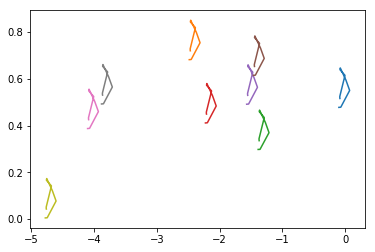

In [23]:
for i,stroke in enumerate(strokes_recon):
    plt.plot(stroke[:,0],stroke[:,1])

# TRAINING

In [14]:
cose.encoder.train()
cose.decoder.train()
cose.embedding_predictive_model.train()
cose.position_predictive_model.train()
optimizer_ae, optimizer_pos_pred, optimizer_emb_pred = optimizers 

In [13]:
loss_ae, loss_pos_pred, loss_emb_pred, loss_total, confidence_emb, confidence_pos, npfig = train_step_v2(train_loader, optimizer_ae, optimizer_pos_pred, optimizer_emb_pred)

/home/ajimenez/CoSE-pytorch/models/gmm.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out_pi = torch.nn.functional.softmax(out_pi)


In [14]:
def eval_step_v2(train_loader, optimizer_ae, optimizer_pos_pred, optimizer_emb_pred):
    i = 0
    for batch_input, batch_target in iter(train_loader):
        break
    enc_inputs, t_inputs, stroke_len_inputs, inputs_start_coord, inputs_end_coord, num_strokes_x_diagram_tensor = parse_inputs(batch_input,cose.device)
    t_target_ink = parse_targets(batch_target,cose.device)
    # Creating sequence length mask
    comb_mask , look_ahead_mask, _ = generate_3d_mask(enc_inputs, stroke_len_inputs, cose.device, cose.config.enc_nhead)
    # Encoder forward
    encoder_out = cose.encoder(enc_inputs, stroke_len_inputs, comb_mask)
    # decoder forward
    encoder_out_reshaped = encoder_out.unsqueeze(dim=1).repeat(1,t_inputs.shape[1],1).reshape(-1, encoder_out.shape[-1])
    t_inputs_reshaped = t_inputs.reshape(-1,1)
    decoder_inp = torch.cat([encoder_out_reshaped, t_inputs_reshaped], dim = 1)
    strokes_out, ae_mu, ae_sigma, ae_pi= cose.decoder(decoder_inp)
    #
    diagram_embedding, padded_max_num_strokes, min_n_stroke, num_diagrams = reshape_stroke2diagram(encoder_out,num_strokes_x_diagram_tensor)
    #
    start_pos_base = inputs_start_coord.reshape(num_diagrams,padded_max_num_strokes,2)
    # PREPARING DATA FOR RELATIONAL ______________
    all_input_emb = []
    all_input_start_pos = []
    all_seq_len_emb = []
    #-----------------------#
    all_target_emb = []
    all_target_start_pos = []
    all_n_inputs = []
    start_n_inputs  = 2
    for number_inp in range(start_n_inputs, min_n_stroke):
        input_indexes, target_indexes, n_inputs = get_arbitrary_ordered_batch(num_strokes_x_diagram_tensor, padded_max_num_strokes, num_diagrams, min_n_stroke, device, n_inputs = number_inp)
        input_embedding = torch.stack([diagram_embedding[diagram_index][input_indexes[diagram_index]] for diagram_index in range(num_diagrams)])
        input_start_pos = torch.stack([start_pos_base[diagram_index][input_indexes[diagram_index]] for diagram_index in range(num_diagrams)])
        target_embedding = torch.stack([diagram_embedding[diagram_index][target_indexes[diagram_index]] for diagram_index in range(num_diagrams)]).squeeze()
        target_start_pos = torch.stack([start_pos_base[diagram_index][target_indexes[diagram_index]] for diagram_index in range(num_diagrams)]).squeeze()
        seq_len_embedding = torch.ones([num_diagrams])*n_inputs
        all_input_emb.append(input_embedding)
        all_input_start_pos.append(input_start_pos)
        all_target_emb.append(target_embedding)
        all_target_start_pos.append(target_start_pos)
        all_seq_len_emb.append(seq_len_embedding)
        all_n_inputs.append(n_inputs)
    sampled_seq_len_emb = torch.stack(all_seq_len_emb)
    sampled_target_start_pos = torch.stack(all_target_start_pos)
    sampled_target_emb = torch.stack(all_target_emb)
    sampled_input_start_pos = torch.zeros(min_n_stroke - start_n_inputs, num_diagrams, max(all_n_inputs),2)
    for i_sample, sampled_data in enumerate(all_input_start_pos):
        for i_diagram, content in enumerate(sampled_data):
            sampled_input_start_pos[i_sample,i_diagram,:int(all_seq_len_emb[i_sample][i_diagram]),:] = content
    sampled_input_emb = torch.zeros(min_n_stroke - start_n_inputs, num_diagrams, max(all_n_inputs),8)
    for i_sample, sampled_data in enumerate(all_input_emb):
        for i_diagram, content in enumerate(sampled_data):
            sampled_input_emb[i_sample,i_diagram,:int(all_seq_len_emb[i_sample][i_diagram]),:] = content
    sampled_input_start_pos = sampled_input_start_pos.reshape(-1, sampled_input_start_pos.size(-2), sampled_input_start_pos.size(-1))
    sampled_input_emb = sampled_input_emb.reshape(-1, sampled_input_emb.size(-2), sampled_input_emb.size(-1))
    sampled_seq_len_emb = sampled_seq_len_emb.reshape(-1)
    sampled_target_start_pos = sampled_target_start_pos.reshape(-1, sampled_target_start_pos.size(-1))
    sampled_target_emb = sampled_target_emb.reshape(-1, sampled_target_emb.size(-1))
    # _______________________________________________________________
    if cose.config.stop_predictive_grad:
        sampled_input_start_pos = sampled_input_start_pos.detach().to(cose.device)
        sampled_input_emb = sampled_input_emb.detach().to(cose.device)
        sampled_seq_len_emb = sampled_seq_len_emb.detach()
        sampled_target_start_pos = sampled_target_start_pos.detach()
        sampled_target_emb = sampled_target_emb.detach() #Detaching gradients of pred_inputs (No influence of Relational Model)
    pos_model_inputs = torch.cat([sampled_input_emb, sampled_input_start_pos], dim = 2)
    tgt_cond = sampled_target_start_pos.squeeze(dim = 1)
    seq_len_inputs = sampled_seq_len_emb.int().to(cose.device)
    seq_mask_rel = 1 - (torch.arange(seq_len_inputs.max().item()).to(cose.device)[None, :] < seq_len_inputs[:, None]).float()
    seq_mask_rel  = seq_mask_rel.masked_fill(seq_mask_rel == 1, float('-inf')).unsqueeze(dim=1).repeat(1,seq_mask_rel.shape[1],1).repeat_interleave(cose.config.rel_nhead,dim = 0)
    emb_pred_mu, emb_pred_sigma, emb_pred_pi = cose.embedding_predictive_model(pos_model_inputs, seq_len_inputs, tgt_cond, src_mask  = seq_mask_rel)

    pos_pred_mu, pos_pred_sigma, pos_pred_pi = cose.position_predictive_model(pos_model_inputs, seq_len_inputs, None, src_mask  = seq_mask_rel)
    # calculating loss

    loss_ae = -1*(logli_gmm_logsumexp(t_target_ink, ae_mu, ae_sigma, ae_pi)[t_target_ink.sum(dim=1) != 0].mean())
    loss_pos_pred = -1*(logli_gmm_logsumexp(sampled_target_start_pos, pos_pred_mu, pos_pred_sigma, pos_pred_pi).mean())
    loss_emb_pred = -1*(logli_gmm_logsumexp(sampled_target_emb, emb_pred_mu, emb_pred_sigma, emb_pred_pi).mean())
    #
    loss_total = loss_pos_pred + loss_emb_pred + loss_ae
    
    pos_pred = cose.position_predictive_model.draw_sample(pos_pred_mu, pos_pred_sigma, pos_pred_pi, greedy = True)
    emb_pred = cose.embedding_predictive_model.draw_sample(emb_pred_mu, emb_pred_sigma, emb_pred_pi, greedy = True)

    emb_pred = emb_pred.reshape(num_diagrams,-1,emb_pred.size(1))[0]
    pos_pred = pos_pred.reshape(num_diagrams,-1,pos_pred.size(1))[0]
    draw_seq_len = np.array([50]*(emb_pred.size(0)))
    #print(pos_model_inputs.reshape(-1,num_diagrams, 7,10)[5][0])
    predicted_batch_stroke = decode_sequence(cose.decoder, emb_pred, draw_seq_len, device)
    npfig, _, _, _ = transform_strokes_to_image(drawing=predicted_batch_stroke.detach().cpu(), seq_len_drawing=draw_seq_len, start_coord_drawing=pos_pred.detach().cpu(), mean_channel=mean_channel,
                                                     std_channel=std_channel, num_strokes=predicted_batch_stroke.shape[0], stroke_pred=None, start_coord_pred=None, output_path=log_dir, output_file="noutput_pruebas", square_figure=True, save=True, alpha=0.6, highlight_start=True)
    
    return (loss_ae, loss_pos_pred, loss_emb_pred, loss_total, emb_pred_pi.max(), pos_pred_pi.max(), npfig)

In [15]:
images = []

In [16]:
from tqdm import tqdm

In [17]:
loss_ae_cum = []
loss_emb_pred_cum = []
loss_pos_pred_cum = []
loss_total_cum = []
confidence_emb_cum = []
confidence_pos_cum = []
n_epochs = 3000

for epoch in tqdm(range(n_epochs)):
    loss_ae, loss_pos_pred, loss_emb_pred, loss_total, confidence_emb, confidence_pos, npfig = train_step_v2(train_loader, optimizer_ae, optimizer_pos_pred, optimizer_emb_pred)
    loss_ae_cum.append(loss_ae.detach().cpu())
    loss_emb_pred_cum.append(loss_emb_pred.detach().cpu())
    loss_pos_pred_cum.append(loss_pos_pred.detach().cpu())
    loss_total_cum.append(loss_total.detach().cpu())
    confidence_emb_cum.append(confidence_emb.item())
    confidence_pos_cum.append(confidence_pos.item())
    if epoch%20==0:
        images.append(npfig)

100%|██████████| 3000/3000 [20:56<00:00,  2.39it/s]


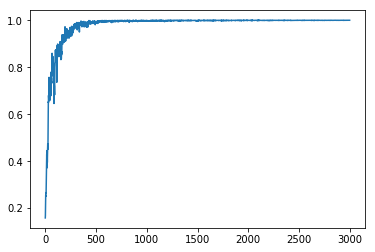

In [19]:
plt.plot([i for i in confidence_emb_cum])

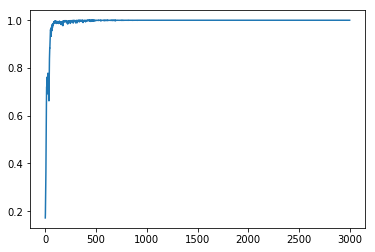

In [20]:
plt.plot([i for i in confidence_pos_cum])

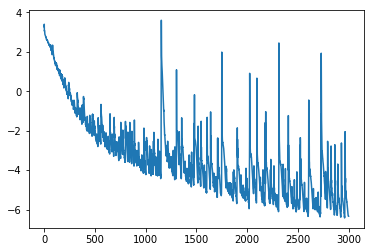

In [21]:
plt.plot([i.item() for i in loss_ae_cum])

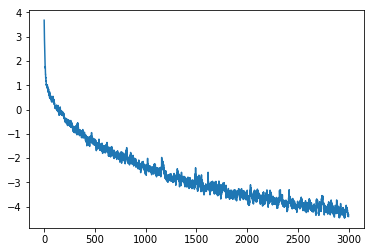

In [22]:
plt.plot([i.item() for i in loss_pos_pred_cum])

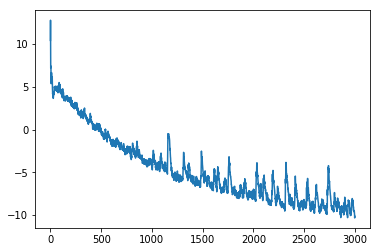

In [23]:
plt.plot([i.item() for i in loss_emb_pred_cum])

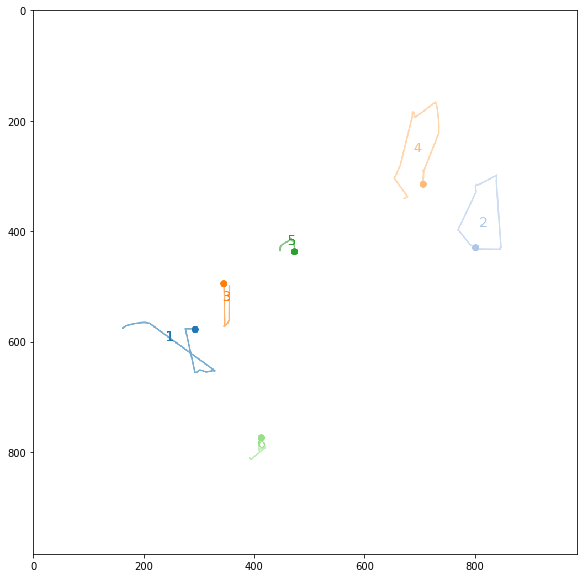

In [24]:
plt.figure(figsize = (10,10))
plt.imshow(images[-4])

In [25]:
for batch_input, batch_target in iter(train_loader):
    break

In [26]:
cose.encoder.eval()
cose.decoder.eval()
cose.embedding_predictive_model.eval()
cose.position_predictive_model.eval()

TransformerGMM(
  (dense1): Linear(in_features=10, out_features=64, bias=True)
  (transformer_decoder): TransformerDecoder(
    (layers): ModuleList(
      (0): TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=64, out_features=64, bias=True)
        )
        (multihead_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.25, inplace=False)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.25, inplace=False)
        (dropout2): Dropout(p=0.25, inplace=False)
        (dropout3): Dropout(p=0.25, inp

In [27]:
enc_inputs, t_inputs, stroke_len_inputs, inputs_start_coord, inputs_end_coord, num_strokes_x_diagram_tensor = parse_inputs(batch_input,cose.device)
t_target_ink = parse_targets(batch_target,cose.device)
# Creating sequence length mask
comb_mask , look_ahead_mask, _ = generate_3d_mask(enc_inputs, stroke_len_inputs, cose.device, cose.config.enc_nhead)
# Encoder forward
encoder_out = cose.encoder(enc_inputs, stroke_len_inputs, comb_mask)
embedding = encoder_out.reshape(num_strokes_x_diagram_tensor.shape[0],-1,8)[0][:num_strokes_x_diagram_tensor[0]]
# decoder forward
draw_seq_len = np.array([50]*(embedding.size(0)))
#
recon_stroke = decode_sequence(cose.decoder, embedding, draw_seq_len, device).detach().cpu()

In [28]:
batch_start_pos = inputs_start_coord.reshape(num_strokes_x_diagram_tensor.shape[0],-1,2)[0][:num_strokes_x_diagram_tensor[0]]

In [29]:
strokes_recon = batch_to_real_stroke_list(recon_stroke, batch_start_pos.unsqueeze(dim = 1).detach().cpu(), draw_seq_len, std_channel, mean_channel, 'cpu')

In [30]:
embedding.shape

torch.Size([9, 8])

In [31]:
len(strokes_recon)

9

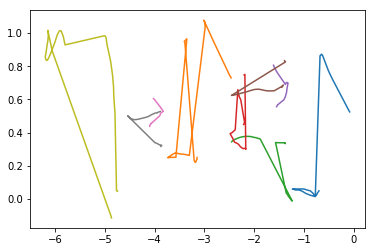

In [32]:
for i,stroke in enumerate(strokes_recon):
    plt.plot(stroke[:,0],stroke[:,1])

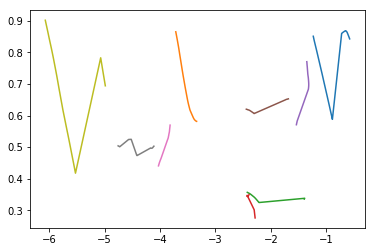

In [34]:
for i,stroke in enumerate(strokes_recon):
    plt.plot(stroke[:,0],stroke[:,1])

In [ ]:
strokes_out.reshape(num_strokes_x_diagram_tensor.shape[0],-1,4,2)[0]

In [ ]:
for i in

In [ ]:
plt.plot()

In [26]:
val_path = f"/data/{user}/cose/test/"

In [27]:
batchdata = BatchCoSELoader(path = val_path,
                    filenames={"inputs_file" : "inputs_list_based.pkl",
                               "targets_file": "target_list_based.pkl"
                              }
                )

valid_loader = DataLoader(
                    dataset =batchdata,
                    batch_size = 1, #data is already in batch mode, batch_size = 1 means iterating every .get_next() returns a new batch
                )
stats_json = 'didi_wo_text-stats-origin_abs_pos.json'
stats_path = '/data/jcabrera/didi_wo_text/'
with open(os.path.join(stats_path, stats_json)) as json_file:
    stats = json.load(json_file)

mean_channel = stats['mean_channel'][:2]
std_channel = np.sqrt(stats['var_channel'][:2])
log_dir = f'/home/ajimenez/pruebas'

In [28]:
eval_loss = AggregateAvg()
models_quant_eval = [cose.embedding_predictive_model, cose.decoder]
models_qual_eval = [cose.position_predictive_model, cose.embedding_predictive_model, cose.decoder]
stats_tuple = [mean_channel, std_channel]

In [29]:
i = 0
for batch_input, batch_target in iter(valid_loader):
    if i == 2:
        break
    i+=1

In [30]:
out_eval_parse_input = eval_parse_input(batch_input, cose.device)
out_eval_parse_target = eval_parse_target(batch_target, cose.device)
encoder_inputs, _, strok_len_inputs, _, _ = out_eval_parse_input
# passing inputs to encoding
comb_mask, look_ahead_mask, _ = generate_3d_mask(encoder_inputs, strok_len_inputs,cose.device, cose.config.enc_nhead)
encoder_out = cose.encoder(encoder_inputs.permute(1,0,2), strok_len_inputs, comb_mask)

In [31]:
print(encoder_out.shape)

torch.Size([21, 8])


In [32]:
%%time
eval_loss, recon_chamfer, pred_chamfer = quantitative_eval_step(encoder_out, out_eval_parse_input, out_eval_parse_target, models_quant_eval, stats_tuple, eval_loss, cose.device, cose.config.rel_nhead )

CPU times: user 1.09 s, sys: 0 ns, total: 1.09 s
Wall time: 924 ms


In [33]:
eval_loss.summary_and_reset()

({'rc_chamfer_stroke': 0.019220714853584016,
  'nll_embedding': 1.2451333,
  'pred_chamfer_stroke': 0.05798228500085573},
 1)

In [34]:
%%time
predicted_batch_stroke, predicted_batch_strat_pos, draw_seq_len = qualitative_eval_step(encoder_out, out_eval_parse_input, out_eval_parse_target, models_qual_eval, stats_tuple, cose.device, cose.config.rel_nhead, num_extra_pred = 5)

CPU times: user 1.51 s, sys: 0 ns, total: 1.51 s
Wall time: 1.51 s


### Old test_strokes